Clean data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data.csv')

In [3]:
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

C:\Users\tosca\AppData\Local\Temp\ipykernel_4064\2903114193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Encoder

In [4]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

In [5]:
le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

ordinal_encoder = OrdinalEncoder(categories=[['Incomplete secondary education', 'Secondary education', 'Secondary special education','Incomplete higher education', 'Higher education', 'PhD degree']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

target_encoder = TargetEncoder(cols=['product_type', 'family_status'], smoothing=1.0)
df[['product_type', 'family_status']] = target_encoder.fit_transform(df[['product_type', 'family_status']], df['bad_client_target'])

df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,1,2.0,0.226908,0,2,21000,0.104080,0,0,0
1,1,19000,6,20,1,2.0,0.076433,1,2,17000,0.104080,3,1,0
2,1,29000,12,23,0,2.0,0.076433,0,2,31000,0.104080,2,0,0
3,1,10000,12,30,1,2.0,0.226908,1,2,31000,0.115385,3,1,0
4,1,14500,12,25,0,4.0,0.226908,0,2,26000,0.139640,0,1,0


Verification de colinéarité

In [6]:
import numpy as np

correlation_matrix = df.corr()
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (correlation_matrix.iloc[i, j] == 1 or correlation_matrix.iloc[i, j] == -1) and i != j :
                print(f"Correlation of 1 or -1 found between '{correlation_matrix.index[i]}' and '{correlation_matrix.columns[j]}'")

Data set

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(columns=['bad_client_target']) # Region and phone op are useless data but better benchmark with 
y = df['bad_client_target'] 

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide dataset 80/20

Standardisation

In [10]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)  # Normalisation des données, (x-µ)/σ où : x = data, µ = moyenne de la colonne, σ = ecart-type de la colonne
X_test_scaled = scaler.transform(X_test)        # Donnée normalisé = même echelle = pas de donnée avec plus de poid

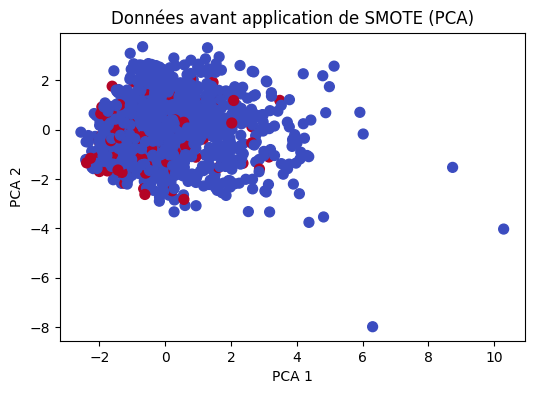

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualiser les données avant rééchantillonnage
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=50)
plt.title("Données avant application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [12]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1378, 13)
y_train shape: (1378,)
X_test shape: (345, 13)
y_test shape: (345,)


Modèle

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier()

# Définir la grille de paramètres
param_grid = {
    'n_estimators': [50, 100, 150],          # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],       # Taux d'apprentissage
    'max_depth': [3, 5, 7],                  # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],         # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4],           # Nombre minimum d'échantillons dans un noeud feuille
    'subsample': [0.8, 1.0]                  # Fraction d'échantillons à utiliser pour chaque arbre
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Entraînez le modèle
grid_search.fit(X_train_scaled, y_train)

# Affichez les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [32]:
gbm = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150, subsample= 0.8)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

In [33]:
# 2. Calculer la précision
accuracy = accuracy_score(y_test, y_pred_gbm)
print(f'Précision : {accuracy:.2f}')

# 3. Générer un rapport de classification
report = classification_report(y_test, y_pred_gbm)
print('Rapport de classification :\n', report)

Précision : 0.89
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       306
           1       0.67      0.05      0.10        39

    accuracy                           0.89       345
   macro avg       0.78      0.52      0.52       345
weighted avg       0.87      0.89      0.85       345



<function matplotlib.pyplot.show(close=None, block=None)>

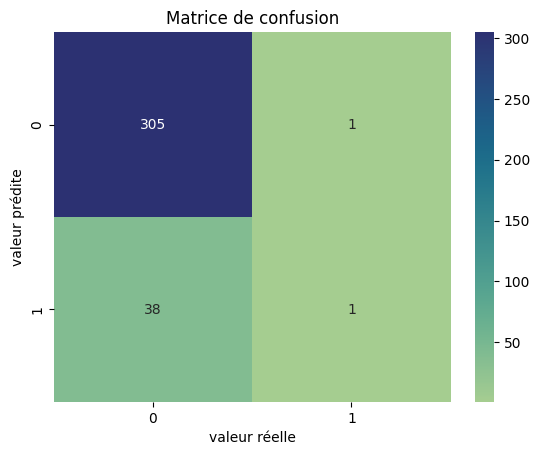

In [27]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(conf_matrix,annot=True, fmt='d', cmap='crest')
plt.title("Matrice de confusion")
plt.xlabel("valeur réelle")
plt.ylabel("valeur prédite")
plt.show